In [21]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [22]:
%matplotlib inline

import pandas as pd
from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
from statsmodels.formula.api import ols, glm
from sklearn.model_selection import train_test_split
from sklearn import decomposition

np.set_printoptions(suppress=True)

In [23]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [24]:
# s1 = selected_009266[:4]
# s2 = selected_009266[-5:]
# selected = s1 + s2  # sessions that have GLM AEP unit fits
# selected
session = selected_009266[-4]
session

'009266_hippoSIT_2023-05-23_09-18-05'

## Build GLM fit params matrix

In [25]:
animal = session.split('_')[0]
aeps_pop_file = os.path.join(source, animal, session, 'AEPs_pop.h5')

# get number of units / AEP metrics
with h5py.File(aeps_pop_file, 'r') as f:
    metrics_count = len([grp for grp in f])
    for grp in f:
        unit_count = np.array(f[grp]['glm_fit_params']).shape[0] - 1
        break

# retrieve GLM fit matrix
AEP_targets = ['P1', 'N1', 'P2', 'P3']  # ensure order
glm_mx = np.zeros([unit_count, metrics_count])
glm_pv = np.zeros([unit_count, metrics_count])
with h5py.File(aeps_pop_file, 'r') as f:
    for i, grp in enumerate(AEP_targets):
        if not grp in f:
            continue
        glm_mx[:, i] = np.array(f[grp]['glm_fit_params'])[1:]  # don't forget first is intercept
        glm_pv[:, i] = np.array(f[grp]['glm_fit_pvalues'])[1:]  # don't forget first is intercept

In [29]:
glm_mx_pv = glm_mx.copy()
for i in range(glm_mx.shape[0]):
    for j in range(glm_mx.shape[1]):
        if glm_pv[i, j] > 0.05:
            glm_mx_pv[i, j] = 0

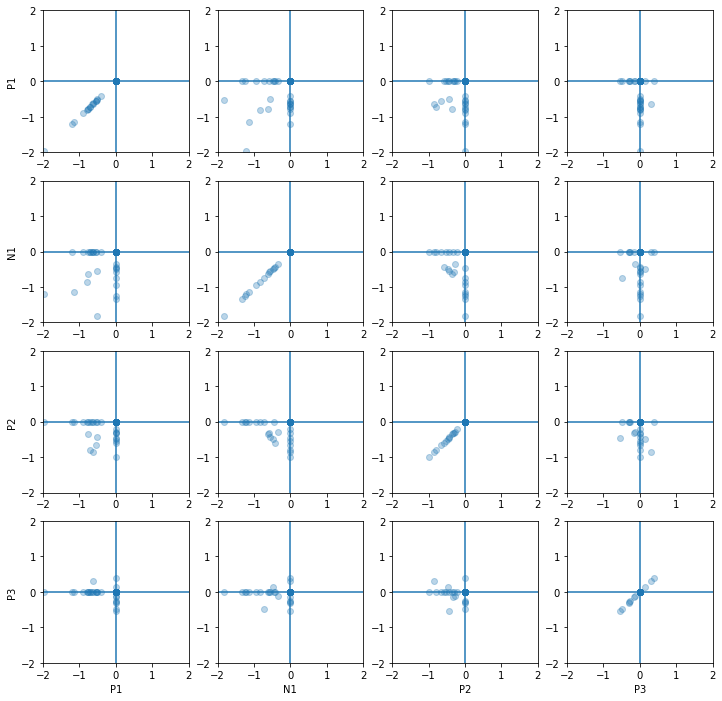

In [31]:
# look at GLM fits across units
# keep only significant ones?
rows = len(AEP_targets)
cols = len(AEP_targets)
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

for i in range(rows):
    for j in range(cols):
        ax = axes[i, j]
        ax.scatter(glm_mx_pv[:, j], glm_mx_pv[:, i], alpha=0.3)
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.axhline(0)
        ax.axvline(0)
        if i == rows - 1:
            ax.set_xlabel(AEP_targets[j])
        if j == 0:
            ax.set_ylabel(AEP_targets[i])

In [20]:
# PCA on GLM fits
pca = decomposition.PCA(n_components=4)
pca.fit(glm_mx)
X = pca.transform(glm_mx)

In [168]:
# plot PCA components
# fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# for comp in pca.components_:
#     ax.plot(comp)

# plot PCA values
# plt.scatter(X[:, 0], X[:, 1])